# Network Anomaly Detection

## Contributors

#### Amr Yasser 6772
#### Elhussein Sabri 6716
#### Marwan Khaled 7020


## References 
[https://www.ecb.torontomu.ca/~bagheri/papers/cisda.pdf](Detailed Analysis of the KDD CUP 99 Data Set Mahbod Tavallaee, Ebrahim Bagheri, Wei Lu, and Ali A. Ghorban)
https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

## Download Datset 

You can Import data set from 
* [KDD CUP 1999 DATA](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
or Download it from kaggle

### Imports

In [8]:
import os

# Import the necessary libraries
from PIL import Image
import numpy as np
import torch 
import pandas as pd
from random import uniform
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Utils

In [10]:
def plot_clusters(model,D):
    x , y = np.hsplit(D,2)
    plt.scatter(x, y, c=model.labels)
    cenx,ceny = np.hsplit(model.centroids,2)
    plt.scatter(cenx,ceny,c='red',marker='*')
    plt.title(f'Cluster at k = {model.n_clusters} after {model.iterations} iterations')

def display_data(D,y,title):
  print(f'\n{title}:')
  print(f'Data shape: {D.shape}')
  df = pd.DataFrame(D)
  df['Id'] = y

  print('\nValue counts:')
  plt.figure(figsize=(12,8))

  sns.countplot(x=df['Id'],color='blue')
  plt.show()



# K-Means Implemenetation

In [26]:
# Define the K-Means algorithm
class kmeans:
    def __init__(self,n_clusters=3, max_iter=300,centroids=[]):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = np.array(centroids)
        self.iterations = 0
    
    def fit(self,train):    
        # Initialize centroids randomly
        min_, max_ = np.min(train, axis=0), np.max(train, axis=0)
        self.centroids = np.array([uniform(min_, max_) for _ in range(self.n_clusters)])
        prev_centroids = np.zeros(self.centroids.shape,dtype='int8')

        while np.not_equal(self.centroids, prev_centroids).any() and self.iterations < self.max_iter:
            prev_centroids = self.centroids.copy()

            # Assign each point to the closest centroid
            distances = np.sqrt(((train - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = np.argmin(distances, axis=0)

            # Update centroids
            for i in range(self.n_clusters):
                self.centroids[i] = np.mean(train[self.labels == i], axis=0)

            # Catch any np.nans, resulting from a centroid having no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  
                    self.centroids[i] = prev_centroids[i]
            
            self.iterations += 1
            
    def Ncut(self):
        pass

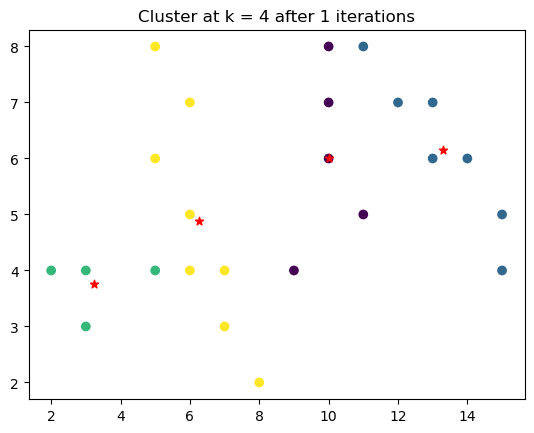

In [27]:
D = np.array([[5,8],[10,8],[11,8],[6,7],[10,7],[12,7],[13,7],[5,6],[10,6],[13,6],[6,5],[9,4],[11,5],[14,6],[15,5],[2,4],[3,4],[5,4],[6,4],[7,4],[15,4],[3,3],[7,3],[8,2]])
# print(D)
kmeans = kmeans(max_iter=1,n_clusters=4)
kmeans.fit(D)
plot_clusters(kmeans,D)


# Normalized Cuts Implementation

In [ ]:
# Define the Normalized Cuts algorithm
def normalized_cuts(data, k):
    # Compute the affinity matrix
    distances = np.sqrt(((data[:, np.newaxis] - data)**2).sum(axis=2))
    sigma = np.median(distances)
    W = np.exp(-distances**2 / (2*sigma**2))

    # Compute the diagonal degree matrix
    D = np.diag(W.sum(axis=1))

    # Compute the Laplacian matrix
    L = D - W

    # Compute the eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the k smallest eigenvectors and normalize them
    X = eigenvectors[:, :k]
    X_norm = X / np.sqrt((X**2).sum(axis=1))[:, np.newaxis]

    # Cluster the normalized eigenvectors using K-Means
    labels = kmeans(X_norm, k)

    return labels

## Extracting Data and formatting

In [7]:
# Open and read the compressed data file using gzip
with gzip.open('/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz', 'rb') as f:
    train = pd.read_csv(f, header=None)

with gzip.open('/kaggle/input/kdd-cup-1999-data/corrected.gz', 'rb') as f:
    test = pd.read_csv(f, header=None)

# Add column names to the DataFrame
cols = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]
train.columns  = cols
test.columns= cols

# View the first few rows of the DataFrame
# print(training_df.head())
# print(testing_df.head())

train.shape
test.shape


(311029, 42)

### Visualization of some labels

In [ ]:

# Visualize the distribution of the 'duration' feature
sns.displot(training_df['duration'], kde=False)

### Pre Processing


In [ ]:
# Convert categorical features to numerical features
le = LabelEncoder()
categorical_columns = training_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    training_df[col] = le.fit_transform(training_df[col])

# Normalization
scaler = StandardScaler()
training_df_scaled = scaler.fit_transform(training_df)

#Visualization
training_df_scaled = pd.DataFrame(training_df_scaled, columns=training_df.columns)
sns.pairplot(training_df_scaled)

## Clustering Using K-Means and Normalized Cut

In [ ]:
# Apply K-Means clustering with different values of K
k_values = [7, 15, 23, 31, 45]
for k in k_values:
    labels_km = kmeans(training_df_scaled, k)
    silhouette_km = silhouette_score(training_df_scaled, labels_km)
    print("Silhouette Score for K-Means Clustering with K=%d: %f" % (k, silhouette_km))

    
# Apply Normalized Cuts clustering
labels_nc = normalized_cuts(training_df_scaled, 5)
silhouette_nc = silhouette_score(training_df_scaled, labels_nc)
print("Silhouette Score for Normalized Cuts Clustering: %f" % silhouette_nc)



## New Clustering Algorithm <Clustering Techinque>

In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df)
labels_db = dbscan.labels_
silhouette_db = silhouette_score(df, labels_db)
print("Silhouette Score for DBSCAN Clustering:", silhouette_db)